Imports :

In [1]:
import torch
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR

Chargement des données

In [2]:
data = fetch_california_housing()
X = data.data
y = data.target
X, y

(array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]))

Affichage de chacunes des features

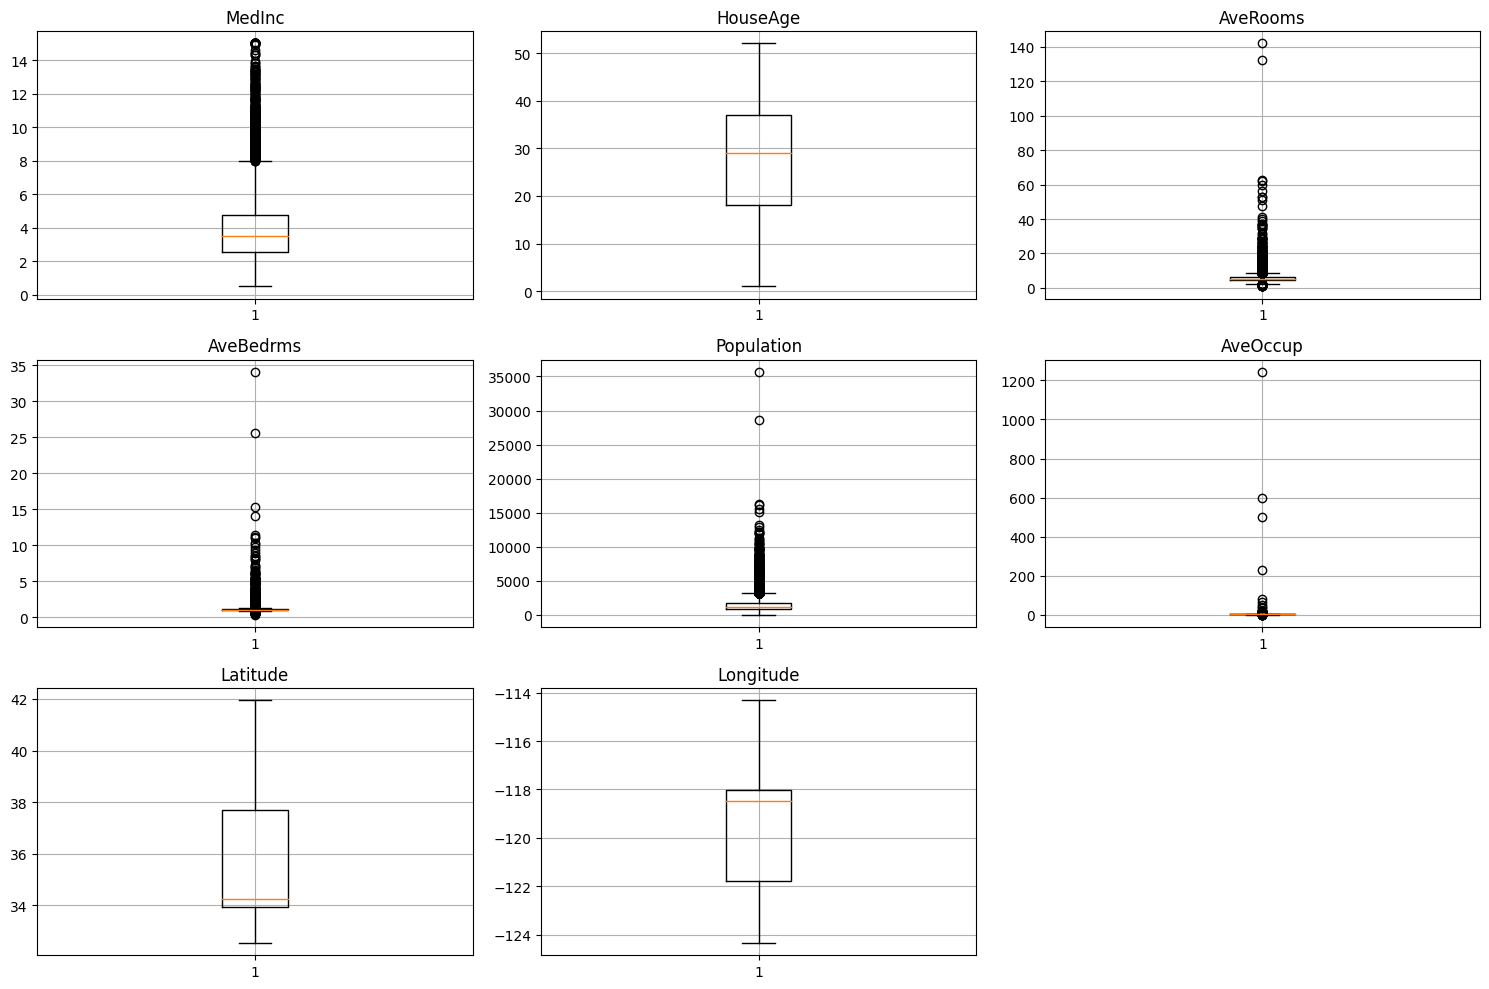

In [3]:
data_df = pd.DataFrame(X, columns=data.feature_names)

# Créer un boxplot pour chaque caractéristique pour détecter les outliers
plt.figure(figsize=(15, 10))
for i in range(len(data.feature_names)):
    plt.subplot(3, 3, i + 1)  # Organiser les graphes en grille de 3x3
    plt.boxplot(data_df[data.feature_names[i]])
    plt.title(data.feature_names[i])
    plt.grid(True)

plt.tight_layout()
plt.show()

Il y a des outliers, on utilise un standard scaler

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Numpy en tenseurs

In [5]:
X_torch = torch.tensor(X_scaled, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32).view(-1, 1)

Split des données : 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size=0.2, random_state=42)

Créer un custom dataset :

In [7]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

Load data

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Modèle de régression

In [9]:
class RegressionModel(nn.Module):
    def __init__(self, n_features, layer_sizes):
        super(RegressionModel, self).__init__()
        layers = []
        
        input_size = n_features
        for size in layer_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            input_size = size
            
        layers.append(nn.Linear(input_size, 1))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Création du modèle

In [10]:
n_features = X_train.shape[1]
layer_sizes = [64, 64, 32]

model = RegressionModel(n_features, layer_sizes)

Paramètres d'entraînement

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
n_epochs = 100
best_model = None
best_val_loss = float('inf')
patience = 20
patience_counter = 0

Training loop

In [12]:
# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    scheduler.step()

    # Perte moyenne sur l'epoch
    train_loss /= len(train_loader.dataset)

    # Validation sur chaque epoch
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Enregistrement du meilleur modèle
        torch.save(model.state_dict(), "best_model_housing.pt")
        patience_counter = 0
        print(f"Meilleur modèle sauvegardé avec une perte de validation de {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}. Meilleure perte de validation: {best_val_loss:.4f}")
        if patience_counter >= patience:
            print("Early stopping triggered. Fin de l'entraînement.")
            break

Epoch 1/100, Train Loss: 0.6724, Validation Loss: 0.5660
Meilleur modèle sauvegardé avec une perte de validation de 0.5660
Epoch 2/100, Train Loss: 0.5213, Validation Loss: 0.4021
Meilleur modèle sauvegardé avec une perte de validation de 0.4021


Résultat de l'entraînement

In [ ]:
total_test_loss = 0
best_model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = best_model(inputs)
        loss = criterion(predictions, targets)
        total_test_loss += loss.item() * inputs.size(0)

total_test_loss /= len(test_loader.dataset)
print(f'Final Test Loss with Best Model: {total_test_loss:.4f}')

AttributeError: 'NoneType' object has no attribute 'eval'